# Final Project - Multi-Planet Mortar Trajectory Python Backend 

#### By: Nick Rader

Link to Front End Site : https://nradermortarlaunch.anvil.app

## Purpose

For the final project of the semester, I decided to further improve upon the my mortar trajectory project by adding more planets where the physics will work a bit differently based on a few variables. I also decided to add a Web App FrontEnd using a technology known as Anvil with is linked to this notebook through an Anvil Server. The FrontEnd webapp will simply call a certain function that will do all the calulations based on the input given by the webapp. 

## Model

The physics involved in this program consist of Drag and the Magnus Effect. Credit to Dr. Titus for showing us how these models worked in class. 

Since I am modeling our trajectory with Drag, I decided to go the same route as Dr.Titus and have the three cases:

- case=0 #no air
- case=1 #C_d is constant and equal to 0.5
- case=2 #C_d depends on speed

I'm also implementing the Magnus Effect, I got to add in all new variables(spinrate,omega,alpha,etc.) just like I did for my second iteration of the my mortar project. Again, credit goes to Dr.Titus for showing us how these formulas work with the new variables to implement the Magnus Effect. We are using backspin for these models.

$$S = \frac{r\omega}{v}$$

$$\vec{F}_{magnus} = \frac{1}{2}C_L \frac{\rho A r}{S} \vec{\omega} \times \vec{v}$$

$$C_L = 0.62S^{0.7}$$

In order to properly model the Magnus Effect and the resulting trajectory we must use an ODE solver. For this project I am using this ODE to to solve for variables in the X,Y,and Z axis (The X and Y are the main ones being used here).

$$\frac{dx}{dt} = v_x \qquad \frac{dy}{dt} = v_y \qquad \frac{dz}{dt} = v_z$$

$$\frac{d v_x}{dt} = \frac{F_{net,x}}{m} \qquad \frac{d v_y}{dt} = \frac{F_{net,y}}{m} \qquad \frac{d v_y}{dt} = \frac{F_{net,y}}{m}$$

## Multi-Planetary Trajectory

With these models in affect, we can determine how far that same type of mortar shell could go on various planets from the video game trilogy of Mass Effect. As I have discovered during my second iteration of my Morter Trajectory Project when I was modeling trajectories on the Planet Tuchanka (which is one of the many popular planets from the series): There are a couple of differences we need to take into account.  

- Gravity - a clear factor upon a trajectory
- Air Density - changes upon two other factors
    - Atmospheric Pressue
    - Surface Temperature

Most of this information can be found using the Mass Effect Wiki, except for Air Density, however using the Atmospheric Pressue and the Surface Temperature of a certain planet we can find out the supposed Air Density of the planet. **Now we will be making the assumption that each of the planets being used will have the same composition of their atmosphere as earth does. Of course since these planets are from a video game so there is likely no information on the atmosphere of the planets so this will be the reason for our assumption.**

Thanks to an online calculator, we were able to use the atmospheric pressue/surface temperature to calculate the air density. This is also assuming each planet's air composition is dry. 

### With all this in mind, we are able to get a rather reasonable and realistic model for a trajectory on another planet. Even if that planet is from a video game.

## Code

### Imports

In [1]:
#import statements
import compy.ode as ode
#incase compy.ode does not work for your computer
#import ode 
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

In [2]:
import anvil.server

anvil.server.connect("44JV6ASSXCV4PQOEXQBC3J46-AIFJWQ4GEWC47KA7")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


### Trajectory on Earth Function

In [3]:
@anvil.server.callable
def create_model_earth(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Earth")
    plt.plot(traj0[:,1], traj0[:,2], 'g.', label='$C_d=0$')
    plt.plot(traj1[:,1], traj1[:,2], 'b.', label='$C_d=0.5$')
    plt.plot(traj2[:,1], traj2[:,2], 'c.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj0[-1,1]
    range1 = traj1[-1,1]
    range2 = traj2[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    
    return traj2

### Trajectory on Tuchanka Function

In [4]:
@anvil.server.callable
def create_model_tuchanka(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_tuc*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_tuc*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_tuc)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_tuc #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_tuc = g*1.14 #N/kg gravity by Tuchanka
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_tuc = 1.12497 #kg/m^3 air density on Tuchanka
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_tuc = 1/2*Cd*rho_tuc*A #drag w/ Tuchanka wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_tuc = 1/2*CL*rho_tuc*A*r/S #alpha on Tuchanka
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj3 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj4 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj5 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Tuchanka")
    plt.plot(traj3[:,1], traj3[:,2], 'g.', label='$C_d=0$')
    plt.plot(traj4[:,1], traj4[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj5[:,1], traj5[:,2], 'r.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj3[-1,1]
    range1 = traj4[-1,1]
    range2 = traj5[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    
    return traj5

### Trajectory on Palaven Function

In [5]:
@anvil.server.callable
def create_model_palaven(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_pal*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_pal*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_pal)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_pal #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_pal = g*1.14 #N/kg gravity by Palaven
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_pal = 1.27661 #kg/m^3 air density on Palaven
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_pal = 1/2*Cd*rho_pal*A #drag w/ Palaven wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_pal = 1/2*CL*rho_pal*A*r/S #alpha on Palaven
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj6 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj7 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj8 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Palaven")
    plt.plot(traj6[:,1], traj6[:,2], 'r.', label='$C_d=0$')
    plt.plot(traj7[:,1], traj7[:,2], 'b.', label='$C_d=0.5$')
    plt.plot(traj8[:,1], traj8[:,2], 'm.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj6[-1,1]
    range1 = traj7[-1,1]
    range2 = traj8[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    
    return traj8

### Trajectory on Sur'Kesh Function

In [6]:
@anvil.server.callable
def create_model_surkesh(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_sur*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_sur*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_sur)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_sur #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_sur = g*0.94 #N/kg gravity by Sur'Kesh
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_sur = 1.68116 #kg/m^3 air density on Sur'Kesh
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_sur = 1/2*Cd*rho_sur*A #drag w/ Sur'Kesh wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_sur = 1/2*CL*rho_sur*A*r/S #alpha on Sur'Kesh
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj9 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj10 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj11 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Sur'Kesh")
    plt.plot(traj9[:,1], traj9[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj10[:,1], traj10[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj11[:,1], traj11[:,2], 'y.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj9[-1,1]
    range1 = traj10[-1,1]
    range2 = traj11[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    
    return traj11

### Trajectory on Rannoch Function

In [7]:
@anvil.server.callable
def create_model_rannoch(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_ran*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_ran*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_ran)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_ran #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_ran = g*0.89 #N/kg gravity by Rannoch
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_ran = 1.02218 #kg/m^3 air density on Rannoch
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_ran = 1/2*Cd*rho_ran*A #drag w/ Rannoch wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_ran = 1/2*CL*rho_ran*A*r/S #alpha on Rannoch
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj12 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj13 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj14 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Rannoch")
    plt.plot(traj12[:,1], traj12[:,2], 'b.', label='$C_d=0$')
    plt.plot(traj13[:,1], traj13[:,2], 'y.', label='$C_d=0.5$')
    plt.plot(traj14[:,1], traj14[:,2], 'g.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj12[-1,1]
    range1 = traj13[-1,1]
    range2 = traj14[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    
    return traj14

### Trajectory on Thessia Function

In [8]:
@anvil.server.callable
def create_model_thessia(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
    
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_the*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_the*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_the)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus(data): # run simulation with case integer
        global b2, alpha_the #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by earth
    g_the = g*1.1 #N/kg gravity by Thessia
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3
    rho_the = 1.13656 #kg/m^3 air density on Thessia
    b2 = 1/2*Cd*rho*A #drag with wind resistance
    b2_the = 1/2*Cd*rho_the*A #drag w/ Thessia wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S 
    alpha_the = 1/2*CL*rho_the*A*r/S #alpha on Thessia
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models
    case = 0 #no air
    traj = run_magnus(d)
    traj15 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus(d)
    traj16 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus(d)
    traj17 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #plot data
    fig = plt.figure(figsize=(12,6))
    plt.title("Mortar Trajectory with Magnus Effect on Thessia")
    plt.plot(traj15[:,1], traj15[:,2], 'y.', label='$C_d=0$')
    plt.plot(traj16[:,1], traj16[:,2], 'm.', label='$C_d=0.5$')
    plt.plot(traj17[:,1], traj17[:,2], 'b.', label='speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    #plt.savefig("trajplot.png",bbox_inches ="tight",facecolor ="w",pad_inches = 1,orientation ='landscape')
    plt.show()
    
    range0 = traj15[-1,1]
    range1 = traj16[-1,1]
    range2 = traj17[-1,1]

    print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
    print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    
    return traj17

### Trajectory of all 6 Planets Comparison (ALL-IN-ONE)

In [9]:
@anvil.server.callable
def create_model_all(launchangle,launchspeed,spinrate):
    
    #Quality of Life Functions
    def mag(v):
        #calculate magnitude of an array
        return np.sqrt(np.dot(v,v))

    def hat(v):
        #calculate unit vector of an array
        return v/mag(v)

    def cross(v1,v2):
        #calculate the cross product of two vectors
        return np.cross(v1,v2)
    
    #Function to change Cd during trajectory calculations
    def getCd(v):
    # calculate value of drag coefficient for a particular speed and case
    
        if case == 0:
            Cd = 0
        elif case == 1:
            Cd = 0.5
        elif case == 2:
            a = 0.36
            b = 0.14
            c = 0.27
            vc = 34
            chi = (v - vc)/4
            if chi < 0:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
            else:
                Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
        else:
            Cd = 0.5
    
        return Cd
        
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus_earth(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus_earth(data): # run simulation with case integer
        global b2, alpha #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus_earth, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus_tuchanka(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_tuc*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_tuc*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_tuc)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus_tuchanka(data): # run simulation with case integer
        global b2, alpha_tuc #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus_tuchanka, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
     #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus_palaven(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_pal*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_pal*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_pal)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus_palaven(data): # run simulation with case integer
        global b2, alpha_pal #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus_palaven, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus_surkesh(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_sur*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_sur*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_sur)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus_surkesh(data): # run simulation with case integer
        global b2, alpha_sur #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus_surkesh, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus_rannoch(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_ran*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_ran*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_ran)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus_rannoch(data): # run simulation with case integer
        global b2, alpha_ran #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus_rannoch, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #Function to model our trajectory array with Magnus Effect before running the simulation.
    def model_magnus_thessia(d, tn):
        #return array of derivatives
        
        #data
        x = d[0]
        y = d[1]
        z = d[2]  
        vx = d[3]
        vy = d[4]
        vz = d[5]
    
        #derivatives
    
        rate = np.zeros(6) #derivatives
        rate[0] = vx
        rate[1] = vy
        rate[2] = vz
    
        #speed
        v = np.array([vx,vy,vz])
        vmag = mag(v)
    
        #calculate force and dv/dt
        Cd=getCd(vmag)
        b2 = 1/2*Cd*rho_the*A
    
        S = r*omegamag/vmag
        CL = 0.62*S**0.7
        alpha = 1/2*CL*rho_the*A*r/S
    
        FM = alpha*cross(omega,v) #magnus force
    
        rate[3] = -b2*vmag*vx/m + FM[0]/m
        rate[4] = (-b2*vmag*vy - m*g_the)/m + FM[1]/m
        rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
        return rate
    
    #simulation with magnus effect
    def run_magnus_thessia(data): # run simulation with case integer
        global b2, alpha_the #need to change the value of b2 and alpha
    
        v = data[3:6]
        vmag = mag(v)

        #time
        t = 0
        h= 0.01
        Nsteps = int(60/h) #simulation goes for 60 seconds

        #store trajectory for plotting or animation
        traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
        traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

        for n in range(0,Nsteps-1):

            #update data
            data = ode.RK4(model_magnus_thessia, data, t, h )

            #update t
            t = t + h
            
            #store data for plotting
            traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
        return traj
    
    #indepdent variables
    m = 20 #mass of mortar(kg)
    g = 9.8 #N/kg gravity by Earth
    g_tuc = g*1.14 #N/kg gravity by Tuchanka
    g_pal = g*1.14 #N/kg gravity by Palaven
    g_sur = g*0.94 #N/kg gravity by Sur'Kesh
    g_ran = g*0.89 #N/kg gravity by Rannoch
    g_the = g*1.1 #N/kg gravity by Thessia
    Cd = 0.7 #drag coefficeint for mortar
    r = (81e-3)/2 #81 mm radius for presicion mortar
    A = np.pi*r**2 #area of mortar 
    rho = 1.2 #kg/m^3 of Earth
    rho_tuc = 1.12497 #kg/m^3 air density on Tuchanka
    rho_pal = 1.27661 #kg/m^3 air density on Palaven
    rho_sur = 1.68116 #kg/m^3 air density on Sur'Kesh
    rho_ran = 1.02218 #kg/m^3 air density on Rannoch
    rho_the = 1.13656 #kg/m^3 air density on Thessia
    b2 = 1/2*Cd*rho*A #drag with Earth wind resistance
    b2_tuc = 1/2*Cd*rho_tuc*A #drag w/ Tuchanka wind resistance
    b2_pal = 1/2*Cd*rho_pal*A #drag w/ Palaven wind resistance
    b2_sur = 1/2*Cd*rho_sur*A #drag w/ Sur'Kesh wind resistance
    b2_ran = 1/2*Cd*rho_ran*A #drag w/ Rannoch wind resistance
    b2_the = 1/2*Cd*rho_the*A #drag w/ Thessia wind resistance
    S = 0.01 #value will change as omega and v change
    CL = 0 #value will change with S
    alpha = 1/2*CL*rho*A*r/S #alpha on Earth
    alpha_tuc = 1/2*CL*rho_tuc*A*r/S #alpha on Tuchanka
    alpha_pal = 1/2*CL*rho_pal*A*r/S #alpha on Palaven
    alpha_sur = 1/2*CL*rho_sur*A*r/S #alpha on Sur'Kesh
    alpha_ran = 1/2*CL*rho_ran*A*r/S #alpha on Rannoch
    alpha_the = 1/2*CL*rho_the*A*r/S #alpha on Thessia
    
    #conversions for input -- uses launchangle & launchspeed
    theta0 = int(launchangle)*(np.pi/180)
    vmag0 = int(launchspeed) * 0.44704
    
    #dependent variables
    x0 = 0 #initial x pos of mortar
    vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
    y0 = 0 #y pos of mortar during initial launch
    vy0 = vmag0*np.sin(theta0)
    z0 = 0
    vz0 = 0
    
    #omega -- uses spinrate
    omegamag = int(spinrate)*2*np.pi/60
    omega = np.array([0,0,omegamag])
    
    #array for velocity and position data
    d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
    #run models earth
    case = 0 #no air
    traj = run_magnus_earth(d)
    traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus_earth(d)
    traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus_earth(d)
    traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #run models tuchanka
    case = 0 #no air
    traj = run_magnus_tuchanka(d)
    traj3 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus_tuchanka(d)
    traj4 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus_tuchanka(d)
    traj5 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #run models palaven
    case = 0 #no air
    traj = run_magnus_palaven(d)
    traj6 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus_palaven(d)
    traj7 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus_palaven(d)
    traj8 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #run models sur'kesh
    case = 0 #no air
    traj = run_magnus_surkesh(d)
    traj9 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus_surkesh(d)
    traj10 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus_surkesh(d)
    traj11 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #run models rannoch
    case = 0 #no air
    traj = run_magnus_rannoch(d)
    traj12 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus_rannoch(d)
    traj13 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus_rannoch(d)
    traj14 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    #run models thessia
    case = 0 #no air
    traj = run_magnus_thessia(d)
    traj15 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 1 #Cd is constant
    traj = run_magnus_thessia(d)
    traj16 = traj[traj[:,2]>=0] #get trajectory data with y>=0

    case = 2
    traj = run_magnus_thessia(d)
    traj17 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
    fig = plt.figure(figsize=(12,6))
    plt.title("Speed Dependent Drag Mortar Launch Comparison")
    plt.plot(traj2[:,1], traj2[:,2], 'c.', label='Earth speed-dependent $C_d$')
    plt.plot(traj5[:,1], traj5[:,2], 'r.', label='Tuchanka speed-dependent $C_d$')
    plt.plot(traj8[:,1], traj8[:,2], 'm.', label='Palaven speed-dependent $C_d$')
    plt.plot(traj11[:,1], traj11[:,2], 'y.', label="Sur'Kesh speed-dependent $C_d$")
    plt.plot(traj14[:,1], traj14[:,2], 'g.', label='Rannoch speed-dependent $C_d$')
    plt.plot(traj17[:,1], traj17[:,2], 'b.', label='Thessia speed-dependent $C_d$')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    plt.show()
    
    range1 = traj2[-1,1]
    range2 = traj5[-1,1]
    range3 = traj8[-1,1]
    range4 = traj11[-1,1]
    range5 = traj14[-1,1]
    range6 = traj17[-1,1]

    print("Variable Cd on Earth: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
    print("Variable Cd on Tuchanka: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))
    print("Variable Cd on Palaven: range = {:.0f} m = {:.0f} ft. ".format(range3, range3*3.28084))
    print("Variable Cd on Sur'Kesh: range = {:.0f} m = {:.0f} ft. ".format(range4, range4*3.28084))
    print("Variable Cd on Rannoch: range = {:.0f} m = {:.0f} ft. ".format(range5, range5*3.28084))
    print("Variable Cd on Thessia: range = {:.0f} m = {:.0f} ft. ".format(range6, range6*3.28084))

## Validation

For our validation we will be testing the difference of spinrate and use what we expect to test the code. For the sake of our spin, and since we are using backspin for our similation we should expect that with more spinrate that our object should be able to go furhter then if there was little to no spinrate. To validate our code we will see two of the same segmenets of code. **Assuming our mortar shell closely represents a normal ball, so really our projectile is more like a cannonball.**

### Little Spinrate Amount

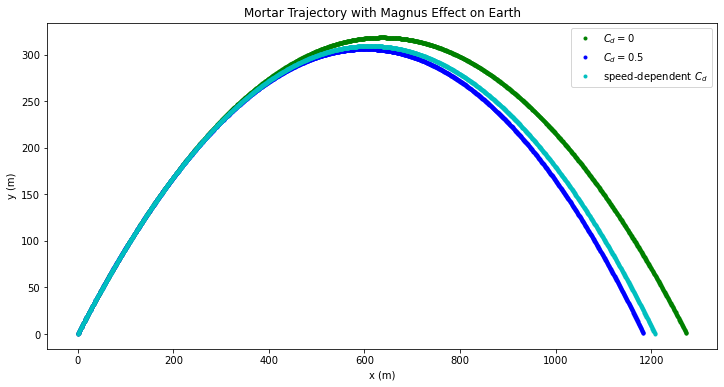

Cd=0: range = 1274 m = 4179 ft. 
Cd=5: range = 1184 m = 3884 ft. 
Variable Cd: range = 1208 m = 3962 ft. 


In [10]:
#Quality of Life Functions
def mag(v):
    #calculate magnitude of an array
    return np.sqrt(np.dot(v,v))

def hat(v):
    #calculate unit vector of an array
    return v/mag(v)

def cross(v1,v2):
    #calculate the cross product of two vectors
    return np.cross(v1,v2)
    
#Function to change Cd during trajectory calculations
def getCd(v):
# calculate value of drag coefficient for a particular speed and case
    
    if case == 0:
        Cd = 0
    elif case == 1:
        Cd = 0.5
    elif case == 2:
        a = 0.36
        b = 0.14
        c = 0.27
        vc = 34
        chi = (v - vc)/4
        if chi < 0:
            Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
        else:
            Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
    else:
        Cd = 0.5
    
    return Cd
    
    
#Function to model our trajectory array with Magnus Effect before running the simulation.
def model_magnus(d, tn):
    #return array of derivatives
        
    #data
    x = d[0]
    y = d[1]
    z = d[2]  
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    #derivatives
    
    rate = np.zeros(6) #derivatives
    rate[0] = vx
    rate[1] = vy
    rate[2] = vz
    
    #speed
    v = np.array([vx,vy,vz])
    vmag = mag(v)
    
    #calculate force and dv/dt
    Cd=getCd(vmag)
    b2 = 1/2*Cd*rho*A
    
    S = r*omegamag/vmag
    CL = 0.62*S**0.7
    alpha = 1/2*CL*rho*A*r/S
    
    FM = alpha*cross(omega,v) #magnus force
    
    rate[3] = -b2*vmag*vx/m + FM[0]/m
    rate[4] = (-b2*vmag*vy - m*g)/m + FM[1]/m
    rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
    return rate
    
#simulation with magnus effect
def run_magnus(data): # run simulation with case integer
    global b2, alpha #need to change the value of b2 and alpha
    
    v = data[3:6]
    vmag = mag(v)

    #time
    t = 0
    h= 0.01
    Nsteps = int(60/h) #simulation goes for 60 seconds

    #store trajectory for plotting or animation
    traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
    traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

    for n in range(0,Nsteps-1):

        #update data
        data = ode.RK4(model_magnus, data, t, h )

        #update t
        t = t + h
            
        #store data for plotting
        traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
    return traj
    
#indepdent variables
m = 20 #mass of mortar(kg)
g = 9.8 #N/kg gravity by earth
Cd = 0.7 #drag coefficeint for mortar
r = (81e-3)/2 #81 mm radius for presicion mortar
A = np.pi*r**2 #area of mortar 
rho = 1.2 #kg/m^3
b2 = 1/2*Cd*rho*A #drag with wind resistance
S = 0.01 #value will change as omega and v change
CL = 0 #value will change with S
alpha = 1/2*CL*rho*A*r/S 

#values put in for validation
launchangle = 45
launchspeed = 250
spinrate = 1
    
#conversions for input -- uses launchangle & launchspeed
theta0 = int(launchangle)*(np.pi/180)
vmag0 = int(launchspeed) * 0.44704
    
#dependent variables
x0 = 0 #initial x pos of mortar
vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
y0 = 0 #y pos of mortar during initial launch
vy0 = vmag0*np.sin(theta0)
z0 = 0
vz0 = 0
    
#omega -- uses spinrate
omegamag = int(spinrate)*2*np.pi/60
omega = np.array([0,0,omegamag])
    
#array for velocity and position data
d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
#run models
case = 0 #no air
traj = run_magnus(d)
traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

case = 1 #Cd is constant
traj = run_magnus(d)
traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

case = 2
traj = run_magnus(d)
traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
#plot data
fig = plt.figure(figsize=(12,6))
plt.title("Mortar Trajectory with Magnus Effect on Earth")
plt.plot(traj0[:,1], traj0[:,2], 'g.', label='$C_d=0$')
plt.plot(traj1[:,1], traj1[:,2], 'b.', label='$C_d=0.5$')
plt.plot(traj2[:,1], traj2[:,2], 'c.', label='speed-dependent $C_d$')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()
    
range0 = traj0[-1,1]
range1 = traj1[-1,1]
range2 = traj2[-1,1]

print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

### Large Spinrate Amount

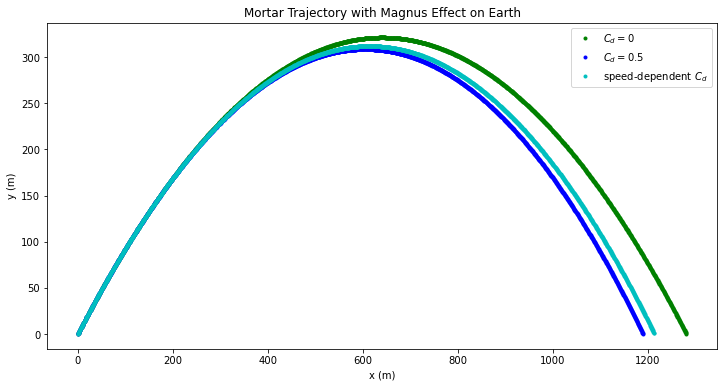

Cd=0: range = 1281 m = 4204 ft. 
Cd=5: range = 1190 m = 3904 ft. 
Variable Cd: range = 1213 m = 3981 ft. 


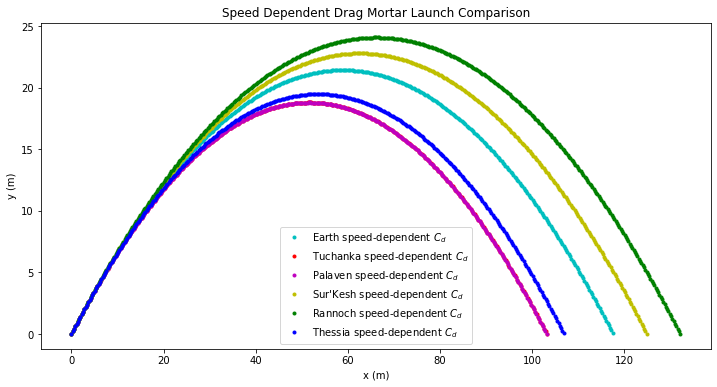

Variable Cd on Earth: range = 118 m = 386 ft. 
Variable Cd on Tuchanka: range = 103 m = 339 ft. 
Variable Cd on Palaven: range = 103 m = 339 ft. 
Variable Cd on Sur'Kesh: range = 125 m = 410 ft. 
Variable Cd on Rannoch: range = 132 m = 434 ft. 
Variable Cd on Thessia: range = 107 m = 351 ft. 


In [11]:
#Quality of Life Functions
def mag(v):
    #calculate magnitude of an array
    return np.sqrt(np.dot(v,v))

def hat(v):
    #calculate unit vector of an array
    return v/mag(v)

def cross(v1,v2):
    #calculate the cross product of two vectors
    return np.cross(v1,v2)
    
#Function to change Cd during trajectory calculations
def getCd(v):
# calculate value of drag coefficient for a particular speed and case
    
    if case == 0:
        Cd = 0
    elif case == 1:
        Cd = 0.5
    elif case == 2:
        a = 0.36
        b = 0.14
        c = 0.27
        vc = 34
        chi = (v - vc)/4
        if chi < 0:
            Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
        else:
            Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
    else:
        Cd = 0.5
    
    return Cd
    
    
#Function to model our trajectory array with Magnus Effect before running the simulation.
def model_magnus(d, tn):
    #return array of derivatives
        
    #data
    x = d[0]
    y = d[1]
    z = d[2]  
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    #derivatives
    
    rate = np.zeros(6) #derivatives
    rate[0] = vx
    rate[1] = vy
    rate[2] = vz
    
    #speed
    v = np.array([vx,vy,vz])
    vmag = mag(v)
    
    #calculate force and dv/dt
    Cd=getCd(vmag)
    b2 = 1/2*Cd*rho*A
    
    S = r*omegamag/vmag
    CL = 0.62*S**0.7
    alpha = 1/2*CL*rho*A*r/S
    
    FM = alpha*cross(omega,v) #magnus force
    
    rate[3] = -b2*vmag*vx/m + FM[0]/m
    rate[4] = (-b2*vmag*vy - m*g)/m + FM[1]/m
    rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
    return rate
    
#simulation with magnus effect
def run_magnus(data): # run simulation with case integer
    global b2, alpha #need to change the value of b2 and alpha
    
    v = data[3:6]
    vmag = mag(v)

    #time
    t = 0
    h= 0.01
    Nsteps = int(60/h) #simulation goes for 60 seconds

    #store trajectory for plotting or animation
    traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
    traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

    for n in range(0,Nsteps-1):

        #update data
        data = ode.RK4(model_magnus, data, t, h )

        #update t
        t = t + h
            
        #store data for plotting
        traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
    return traj
    
#indepdent variables
m = 20 #mass of mortar(kg)
g = 9.8 #N/kg gravity by earth
Cd = 0.7 #drag coefficeint for mortar
r = (81e-3)/2 #81 mm radius for presicion mortar
A = np.pi*r**2 #area of mortar 
rho = 1.2 #kg/m^3
b2 = 1/2*Cd*rho*A #drag with wind resistance
S = 0.01 #value will change as omega and v change
CL = 0 #value will change with S
alpha = 1/2*CL*rho*A*r/S 

#values put in for validation
launchangle = 45
launchspeed = 250
spinrate = 1000
    
#conversions for input -- uses launchangle & launchspeed
theta0 = int(launchangle)*(np.pi/180)
vmag0 = int(launchspeed) * 0.44704
    
#dependent variables
x0 = 0 #initial x pos of mortar
vx0 = vmag0*np.cos(theta0) #initial x vel of mortar
y0 = 0 #y pos of mortar during initial launch
vy0 = vmag0*np.sin(theta0)
z0 = 0
vz0 = 0
    
#omega -- uses spinrate
omegamag = int(spinrate)*2*np.pi/60
omega = np.array([0,0,omegamag])
    
#array for velocity and position data
d = np.array([x0,y0,z0,vx0,vy0,vz0]) #initialize dependent variables
    
#run models
case = 0 #no air
traj = run_magnus(d)
traj0 = traj[traj[:,2]>=0] #get trajectory data with y>=0

case = 1 #Cd is constant
traj = run_magnus(d)
traj1 = traj[traj[:,2]>=0] #get trajectory data with y>=0

case = 2
traj = run_magnus(d)
traj2 = traj[traj[:,2]>=0] #get trajectory data with y>=0
    
#plot data
fig = plt.figure(figsize=(12,6))
plt.title("Mortar Trajectory with Magnus Effect on Earth")
plt.plot(traj0[:,1], traj0[:,2], 'g.', label='$C_d=0$')
plt.plot(traj1[:,1], traj1[:,2], 'b.', label='$C_d=0.5$')
plt.plot(traj2[:,1], traj2[:,2], 'c.', label='speed-dependent $C_d$')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()
    
range0 = traj0[-1,1]
range1 = traj1[-1,1]
range2 = traj2[-1,1]

print("Cd=0: range = {:.0f} m = {:.0f} ft. ".format(range0, range0*3.28084))
print("Cd=5: range = {:.0f} m = {:.0f} ft. ".format(range1, range1*3.28084))
print("Variable Cd: range = {:.0f} m = {:.0f} ft. ".format(range2, range2*3.28084))

**Like we expected our code correctly represents our outcome and our projectile is able to travel further with more spinrate in a backspin model. Therefore our code is correct for our expected outcome.**

## References

- Most of the code seen here can be credited to Dr. Titus for he was the one who provided us the knowlegde of how these systems worked as well as provided code to simulate realistic projectile motion using the magnus effect. 

- The use of anvil technologies allowed me to have a webapp front end while also having a jupyter notebook backend for this project so props to them and their use of anvil server.

- https://www.omnicalculator.com/physics/air-density 

This site above allowed me to calculate the air density using specific variables granted by Mass Effect Wiki(link below)

- https://masseffect.fandom.com/wiki/Planets